# G-Research Crypto Forecasting
## Use your ML expertise to predict real crypto market data

## 1. Problem Understanding

The general research associated with the market is highly focusing on neither buy or sell. The common trend towards the stock market among the society is that it is highly risky for investment or not suitable for trade so most of the people are not even interested. The seasonal variance and steady flow of any index will help both existing and inexperienced investors to understand and make a decision to invest in the stock market.

To solve these types of problems, the time series analysis will be the best tool for forecasting the trend or even future. The trend chart will provide adequate guidance for the investors.

So let us understand this concept in great detail and use a machine learning technique to forecast stocks.

Over $40 billion worth of cryptocurrencies are traded every day. They are among the most popular assets for speculation and investment, yet have proven wildly volatile. Fast-fluctuating prices have made millionaires of a lucky few, and delivered crushing losses to others. Could some of these price movements have been predicted in advance?

## 2. Our Goal is:
To forecast short term returns on the most popular cryptocurrencies

## 3. Data Understanding
#### 3.1. Data volume (size, number of records)
        - The size of the dataset is : 3.06 GB
        - number of files in csv: 5 
                - train.csv(2.82 GB)
                - example_test.csv(5.92 kB)
                - asset_details.csv(444 B)
                - example_sample_submission.csv(406 B)
                - supplemental_train.csv(243.24 MB)
#### 3.2. Data attributes and their description (variables, data types)
        - files variable: 
        train.csv - The training set
*               **timestamp** - A timestamp for the minute covered by the row.
*                **Asset_ID** - An ID code for the cryptoasset.
*                **Count** - The number of trades that took place this minute.
*                **Open** - The USD price at the beginning of the minute.
*                **High** - The highest USD price during the minute.
*                **Low** - The lowest USD price during the minute.
*                **Close** - The USD price at the end of the minute.
*                **Volume** - The number of cryptoasset units traded during the minute.
*                **VWAP** - The volume weighted average price for the minute.
*                **Target** - 15 minute residualized returns. See the 'Prediction and Evaluation' section of this notebook for details of how the target is calculated.


        example_test.csv - An example of the data that will be delivered by the time series API.

        example_sample_submission.csv - An example of the data that will be delivered by the time series API. The data is just copied from train.csv.

        asset_details.csv - Provides the real name and of the cryptoasset for each Asset_ID and the weight each cryptoasset receives in the metric.

        gresearch_crypto - An unoptimized version of the time series API files for offline work. You may need Python 3.7 and a Linux environment to run it without errors.

        supplemental_train.csv - After the submission period is over this file's data will be replaced with cryptoasset prices from the submission period. In the Evaluation phase, the train, train supplement, and test set will be contiguous in time, apart from any missing data. The current copy, which is just filled approximately the right amount of data from train.csv is provided as a placeholder.
#### 3.3. Relationship and mapping schemes (understand attribute representations)
These financial charts are named candlesticks because the rectangular shape and lines on either end represent a candle with wicks. Each candlestick resembles one minute’s worth of price data of stock. With time, the candlesticks group into recognizable patterns that investors use for making buying and selling decisions.
![How to easily understand the candlestick chart in the stock market](http://qph.fs.quoracdn.net/main-qimg-3543e6c07485ced5fa0c7ff35f54081e)
#### 3.4. Basic descriptive statistics (mean, median, variance)
#### 3.5. Focus on which attributes are important for the business

In [1]:
!pip install pmdarima

     |████████████████████████████████| 1.4 MB 287 kB/s 


In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import rcParams
plt.style.use('fivethirtyeight')
import plotly.express as px
from datetime import datetime
import plotly.graph_objects as go
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Load the training set

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/g-research-crypto-forecasting/example_sample_submission.csv
/kaggle/input/g-research-crypto-forecasting/asset_details.csv
/kaggle/input/g-research-crypto-forecasting/example_test.csv
/kaggle/input/g-research-crypto-forecasting/train.csv
/kaggle/input/g-research-crypto-forecasting/supplemental_train.csv
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so
/kaggle/input/g-research-crypto-forecasting/gresearch_crypto/__init__.py


In [4]:
path = "../input/g-research-crypto-forecasting/"
train = pd.read_csv(path + "train.csv")
#train.index = pd.to_datetime(train.index, unit='s')
train['timestamp'] = pd.to_datetime(train['timestamp'], unit='s')
train = train.set_index('timestamp')

asset_details = pd.read_csv(path + "asset_details.csv")

supplemental_train = pd.read_csv(path + "supplemental_train.csv")
# Converting the timestamp from string to timestamp format:
supplemental_train.index = pd.to_datetime(supplemental_train.index, unit='s')
example_test = pd.read_csv(path + "example_test.csv")
train.head(8)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
2018-01-01 00:01:00,2,40.0,2376.5800,2399.5000,2357.1400,2374.590000,19.233005,2373.116392,-0.004218
2018-01-01 00:01:00,0,5.0,8.5300,8.5300,8.5300,8.530000,78.380000,8.530000,-0.014399
2018-01-01 00:01:00,1,229.0,13835.1940,14013.8000,13666.1100,13850.176000,31.550062,13827.062093,-0.014643
2018-01-01 00:01:00,5,32.0,7.6596,7.6596,7.6567,7.657600,6626.713370,7.657713,-0.013922
2018-01-01 00:01:00,7,5.0,25.9200,25.9200,25.8740,25.877000,121.087310,25.891363,-0.008264
2018-01-01 00:01:00,6,173.0,738.3025,746.0000,732.5100,738.507500,335.987856,738.839291,-0.004809
2018-01-01 00:01:00,9,167.0,225.3300,227.7800,222.9800,225.206667,411.896642,225.197944,-0.009791
2018-01-01 00:01:00,11,7.0,329.0900,329.8800,329.0900,329.460000,6.635710,329.454118,NaN


Here we can see that each row of our dataset has the trading data for an asset, at a given minute timestamp, described in the first 8 rows of the table below.

In [5]:
train.tail(3)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
2021-09-21,13,380.0,0.091390,0.091527,0.091260,0.091349,2.193732e+06,0.091388,NaN
2021-09-21,12,177.0,0.282168,0.282438,0.281842,0.282051,1.828508e+05,0.282134,NaN
2021-09-21,11,48.0,232.695000,232.800000,232.240000,232.275000,1.035123e+02,232.569697,NaN


In [6]:
train.describe()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
count,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423681e+07,2.423680e+07,2.348647e+07
mean,6.292544e+00,2.864593e+02,1.432640e+03,1.436350e+03,1.429568e+03,1.432640e+03,2.868530e+05,NaN,7.121752e-06
std,4.091861e+00,8.673982e+02,6.029605e+03,6.039482e+03,6.020261e+03,6.029611e+03,2.433935e+06,NaN,5.679042e-03
min,0.000000e+00,1.000000e+00,1.170400e-03,1.195000e-03,2.000000e-04,1.171400e-03,-3.662812e-01,-inf,-5.093509e-01
25%,3.000000e+00,1.900000e+01,2.676500e-01,2.681600e-01,2.669000e-01,2.676483e-01,1.410725e+02,2.676368e-01,-1.694354e-03
50%,6.000000e+00,6.400000e+01,1.428860e+01,1.431250e+01,1.426300e+01,1.428920e+01,1.295415e+03,1.428769e+01,-4.289844e-05
75%,9.000000e+00,2.210000e+02,2.288743e+02,2.293000e+02,2.284200e+02,2.288729e+02,2.729764e+04,2.288728e+02,1.601520e-03
max,1.300000e+01,1.650160e+05,6.480594e+04,6.490000e+04,6.467053e+04,6.480854e+04,7.597554e+08,inf,9.641699e-01


Printing the DataFrame’s info, we can see all that it contains:

### 4. Exploratory Data Analysis

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24236806 entries, 2018-01-01 00:01:00 to 2021-09-21 00:00:00
Data columns (total 9 columns):
 #   Column    Dtype  
---  ------    -----  
 0   Asset_ID  int64  
 1   Count     float64
 2   Open      float64
 3   High      float64
 4   Low       float64
 5   Close     float64
 6   Volume    float64
 7   VWAP      float64
 8   Target    float64
dtypes: float64(8), int64(1)
memory usage: 1.8 GB


**asset_details.csv** - Provides the real name and of the cryptoasset for each Asset_ID and the weight each cryptoasset receives in the metric.

In [8]:
asset_details

,Asset_ID,Weight,Asset_Name
0,2,2.397895,Bitcoin Cash
1,0,4.304065,Binance Coin
2,1,6.779922,Bitcoin
3,5,1.386294,EOS.IO
4,7,2.079442,Ethereum Classic
5,6,5.894403,Ethereum
6,9,2.397895,Litecoin
7,11,1.609438,Monero
8,13,1.791759,TRON
9,12,2.079442,Stellar


In [9]:
train.shape

(24236806, 9)

In [10]:
train.isnull().sum()

Asset_ID         0
Count            0
Open             0
High             0
Low              0
Close            0
Volume           0
VWAP             9
Target      750338
dtype: int64

In [11]:
import plotly.express as px
asset_details = asset_details.sort_values(by='Weight', ascending=False)
fig = px.bar(asset_details, x='Asset_Name', y='Weight', title="The Cryptomoney with their Weight")
fig.show()

Let's visualize the per day closing price of the stock.

In [12]:
btc = train[train["Asset_ID"]==1] # Asset_ID = 1 for Bitcoin
btc_mini = btc.iloc[-200:] # Select recent data rows

eth = train[train["Asset_ID"]==6] # Asset_ID = 6 for eth
eth_mini = eth.iloc[-200:] # Select recent data rows

crd = train[train["Asset_ID"]==3] # Asset_ID = 3 for eth
crd_mini = crd.iloc[-400:] # Select recent data rows

bc = train[train["Asset_ID"]==0] # Asset_ID = 0 for eth
bc_mini = bc.iloc[-400:] # Select recent data rows

dg = train[train["Asset_ID"]==4] # Asset_ID = 4 for eth
dg_mini = dg.iloc[-400:] # Select recent data rows

ltc = train[train["Asset_ID"]==9] # Asset_ID = 9 for eth

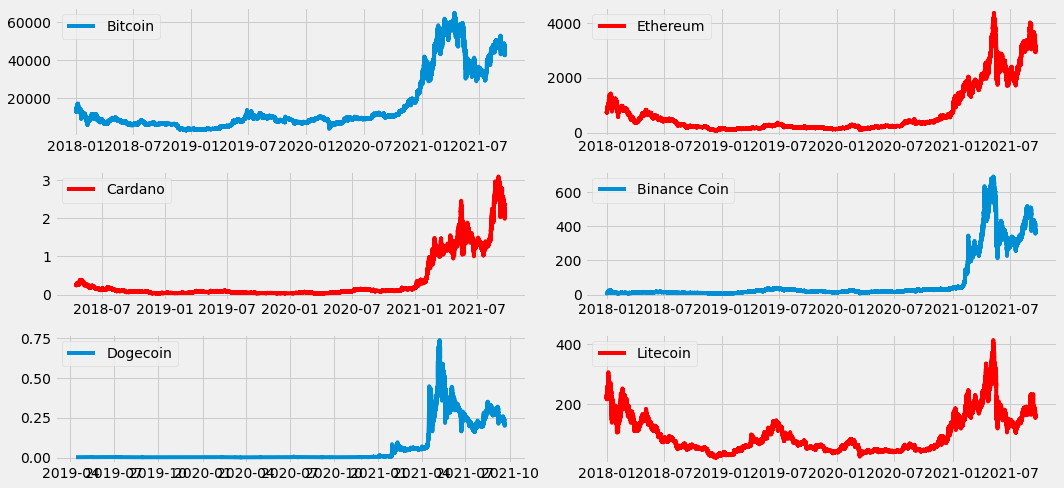

In [13]:
import matplotlib.pyplot as plt

f = plt.figure(figsize=(15,7))
ax = f.add_subplot(321)
plt.plot(btc['Close'], label='Bitcoin')
plt.legend()

ax2 = f.add_subplot(322)
ax2.plot(eth['Close'], label='Ethereum', color='red')
plt.legend()

ax3 = f.add_subplot(323)
ax3.plot(crd['Close'], label='Cardano', color='red',)
plt.legend()

ax2 = f.add_subplot(324)
ax2.plot(bc['Close'], label='Binance Coin')
plt.legend()

ax2 = f.add_subplot(325)
ax2.plot(dg['Close'], label='Dogecoin')
plt.legend()

ax2 = f.add_subplot(326)
ax2.plot(ltc['Close'], label='Litecoin', color='red')
plt.legend()
plt.tight_layout()
plt.show()

In [14]:
import plotly.graph_objects as go

def plotcandlcharts(monaie, title):
    fig = go.Figure(data=[go.Candlestick(x=monaie.index, open=monaie['Open'], high=monaie['High'], low=monaie['Low'], close=monaie['Close'])])
    fig.update_layout(
        title=title,
        xaxis_title="Time",
        yaxis_title="Stock")

    fig.show()
plotcandlcharts(btc_mini,'Candlestick Trading for BITCOIN the latest day')
plotcandlcharts(eth_mini,'Candlestick Trading for ETHERUM the latest day')
plotcandlcharts(crd_mini,'Candlestick Trading for CARDINO the latest day')

In [15]:
train1 = pd.read_csv("../input/g-research-crypto-forecasting/train.csv")

asset_details = pd.read_csv("../input/g-research-crypto-forecasting/asset_details.csv")
mapping = dict(asset_details[['Asset_ID', 'Asset_Name']].values)
train1["Asset name"] = train1["Asset_ID"].map(mapping)

bitcoin = train1.query("Asset_ID == 1").reset_index(drop = True)
bitcoin['timestamp'] = pd.to_datetime(bitcoin['timestamp'], unit='s')
bitcoin = bitcoin.set_index('timestamp')
bitcoin

ethereum = train1.query("Asset_ID == 6").reset_index(drop = True)
ethereum['timestamp'] = pd.to_datetime(ethereum['timestamp'], unit='s')
ethereum = ethereum.set_index('timestamp')
ethereum

cardano = train1.query("Asset_ID == 3").reset_index(drop = True)
cardano['timestamp'] = pd.to_datetime(cardano['timestamp'], unit='s')
cardano = cardano.set_index('timestamp')
cardano.head(1)

maker = train1.query("Asset_ID == 10").reset_index(drop = True)
maker['timestamp'] = pd.to_datetime(maker['timestamp'], unit='s')
maker = maker.set_index('timestamp')

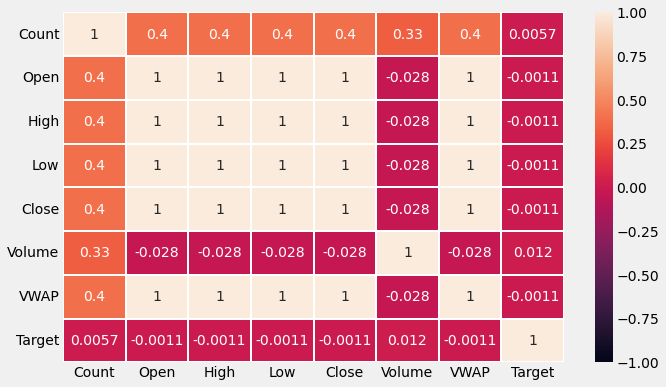

In [16]:
import seaborn as sns
plt.figure(figsize=(10,6))
sns.heatmap(train[['Count','Open','High','Low','Close','Volume','VWAP','Target']].corr(), vmin=-1.0, vmax=1.0, annot=True, linewidths=0.1)
plt.show()

## Is Our dataset Stationary data

### What is a stationary series?

1. The average of the series should not be in function of time. The red graph below is not stationary as the average increases over time.
![](https://assets.moncoachdata.com/v7/moncoachdata.com/wp-content/uploads/2020/01/moyenne-series-temporelles-stationnaires.png?w=555)

2. The variance of the series must not be in function of time. Notice in the red graph below the variance of the data that varies over time.
![](https://assets.moncoachdata.com/v7/moncoachdata.com/wp-content/uploads/2020/01/variance-series-temporelles-stationnaires.png?w=555)

3. Finally, the covariance of the i-th term and the (i + m)-th term must not be a function of time. In the following graph, you will notice that the gap gets closer as time increases. Therefore, the covariance is not related to time for the “red series”.
![](https://assets.moncoachdata.com/v7/moncoachdata.com/wp-content/uploads/2020/01/covariance-series-temporelles-stationnaires.png?w=555)

If a time series is stationary and exhibits a particular behavior during a given time interval, it is safe to assume that it will exhibit the same behavior at a later time. Most statistical modeling methods assume or require the time series to be stationary.

As mentioned earlier, before we can build a model, we need to make sure that the time series is stationary. There are two main ways to determine if a given time series is stationary:

* **Rolling statistics** : Plot the moving average and moving standard deviation. The time series is stationary if it remains constant over time (by eye, look to see if the lines are straight and parallel to the x axis)
* **Augmented Dickey-Fuller (ADF) test**: The time series is considered stationary if the p-value is small (according to the null hypothesis) and if the critical values at 1%, 5%, 10% confidence intervals are as close as possible to the ADF statistics.

For those who don't understand the difference between average and moving average, a 10-day moving average calculates the average of the closing prices of the first 10 days as the first data point. And so on for each subsequent data point.

In [17]:
df_close_bitcoin = bitcoin['Close']
df_close_ethereum = ethereum['Close']
df_close_cardano = cardano['Close']
df_close_maker = maker['Close']

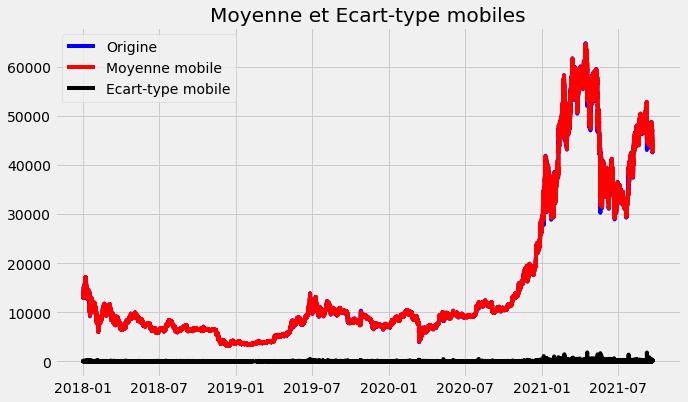

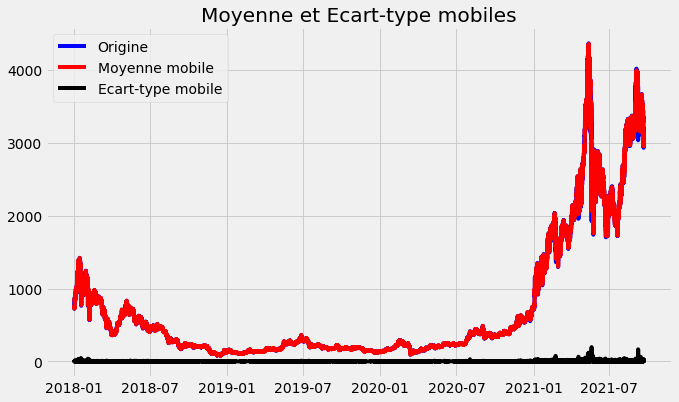

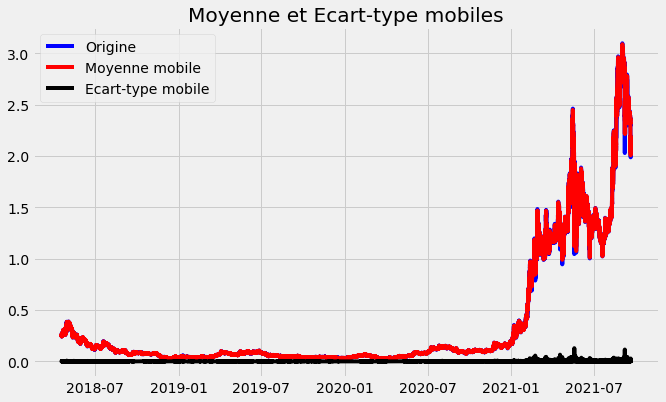

In [18]:
def test_stationarity(df_close):
    plt.figure(figsize=(10,6))
    rolling_mean = df_close.rolling(window = 12).mean()
    rolling_std = df_close.rolling(window = 12).std()
    plt.plot(df_close, color = 'blue', label = 'Origine')
    plt.plot(rolling_mean, color = 'red', label = 'Moyenne mobile')
    plt.plot(rolling_std, color = 'black', label = 'Ecart-type mobile')
    plt.legend(loc = 'best')
    plt.title('Moyenne et Ecart-type mobiles')
    plt.show()
    
test_stationarity(df_close_bitcoin)
test_stationarity(df_close_ethereum)
test_stationarity(df_close_cardano)

As you can see, the moving average and the moving standard deviation increase with time. We can therefore conclude that the time series is not stationary.

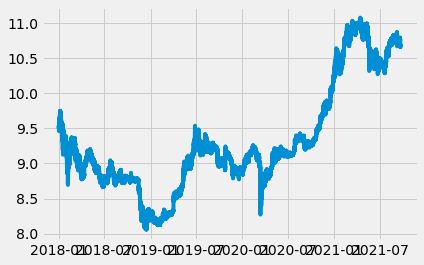

In [19]:
df_log = np.log(df_close_bitcoin)
plt.plot(df_log)

<Figure size 432x288 with 0 Axes>

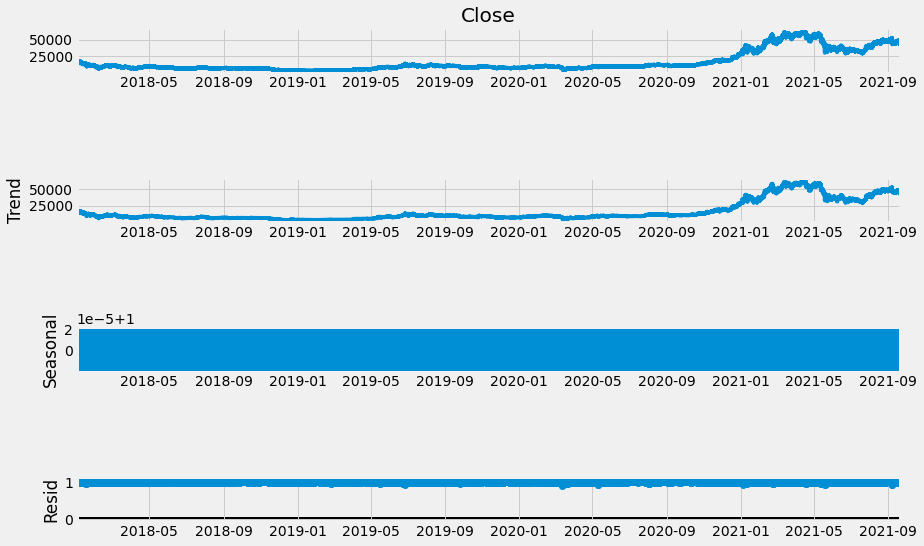

In [20]:
result = seasonal_decompose(df_close_bitcoin, model='multiplicative', period = 30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

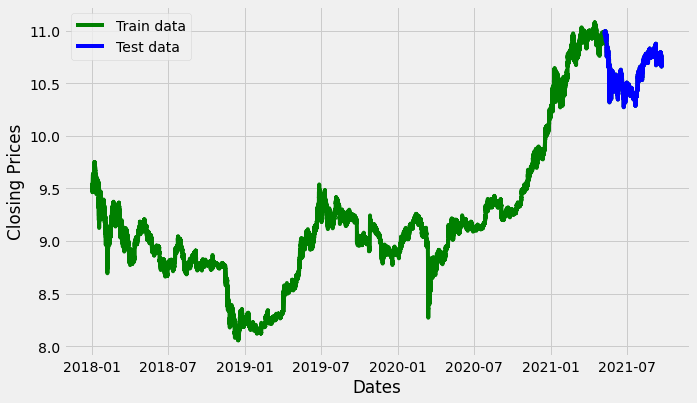

In [21]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning:


statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)




RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  4.85217D+00    |proj g|=  1.77636D-07


 This problem is unconstrained.



           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    3      1      3      1     0     0   1.776D-07   4.852D+00
  F =   4.8521722846668451     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:              1956280
Model:                 ARIMA(2, 1, 0)   Log Likelihood            -9492207.597
Method:                       css-mle   S.D. of innovations             30.977
Date:                Tue, 01 Feb 2022   AIC                       18984423.194
Time:                       

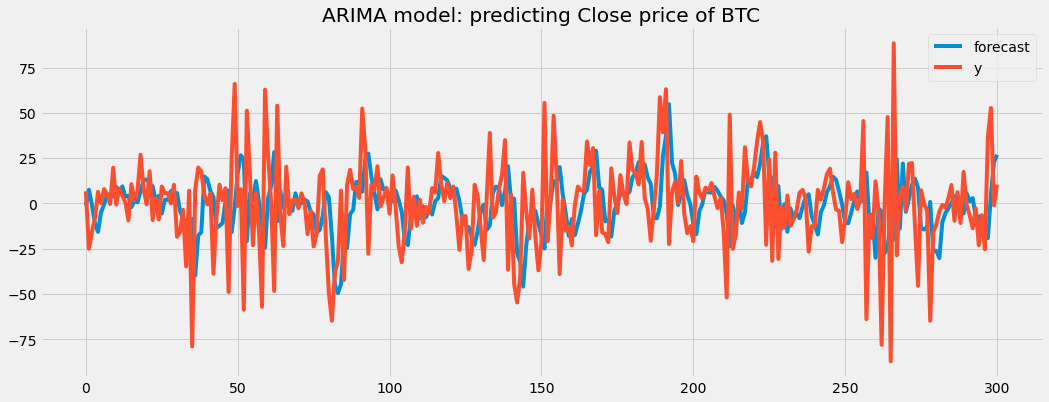

In [22]:
# Predicting the close price of BTC  
rcParams['figure.figsize'] = 16, 6
model = ARIMA(bitcoin["Close"].diff().iloc[1:].values, order=(2,1,0))
result = model.fit()
print(result.summary())
result.plot_predict(start=700, end=1000)
_ = plt.title('ARIMA model: predicting Close price of BTC')
plt.show()

In [23]:
import math
count = len(btc["Close"].diff().iloc[1000:1101].values)
rmse = math.sqrt(mean_squared_error(bitcoin["Close"].diff().iloc[1000:1101].values, result.predict(start=1000,end=999+count)))
print("The root mean squared error is {}.".format(rmse))

The root mean squared error is 38.682195216477034.


In [24]:
bitcoin['timestamp'] = bitcoin.index

In [25]:
predicted_result = result.predict()

In [26]:
import gresearch_crypto
env = gresearch_crypto.make_env()   # initialize the environment
iter_test = env.iter_test()    # an iterator which loops over the test set and sample submission
for (df_test, sample_prediction_df) in iter_test:
    sample_prediction_df['Target'] = 0  # make your predictions here
    env.predict(sample_prediction_df)   # register your predictions

This version of the API is not optimized and should not be used to estimate the runtime of your code on the hidden test set.
